# Project milestone 3

This last notebook presents the final results of our work. After producing a detailed analysis of the different datasets, we focused our analysis on three datasets to produce the most optimal analysis and presentation of results.
These datasets are:
* Stack Overflow
* Wikipedia
* [Crowdedness at the Gym Campus](https://www.kaggle.com/nsrose7224/crowdedness-at-the-campus-gym/version/2)


These three datasets allow us to find the same trends that we will present below.
A report is also available here offering a more detailed and organized analysis.
Hoping that you will enjoy our work.

In [13]:
import re
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from ipywidgets import interact

import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime, timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Daylight Saving Time impact on Stack Overflow posts

# Wikipedia Data

We generated a dataset based on the Wikipedia data to complete our analysis with a validation with another data source.
To obtain this data, we wrote a simple Python script, which makes use of the Wikipedia API (https://www.mediawiki.org/wiki/API:Recent_changes_stream).

Wikipedia only allow their users to get the last 30 days changes. Relative to the moment we finished writing the script, we chose a period of 31 days, from 2018-10-18 13:38:21 to 2018-11-17 00:00:15, in other words, 17 days before the hour change and 13 days after.

This time window is relevant for our problem, because we need to analyze a long-period behavior evolution of users.

The number of changes per second in Wikipedia is large. That's why we had to limit the number of changes we got (31 days of changes represent  approximately 560 GB of data).

We got the 100th first changes each 15 minutes for our time period to limit the amount of data to be stored.

Because of this choice, we can't compare the number of changes before and after the hour change. We have to find others indicators to validate our theories.

### Wikipedia changes API request format

A sample API request looks like this:
https://en.wikipedia.org/w/api.php?action=query&format=json&list=recentchanges&rcprop=ids%7Csizes%7Cfrcshow=!bot%7Clags%7Cuserid%7Ctimestamp&rclimit=100&rcstart='+wikistamp+'&rcdir=newer

The parameters used for the API requests have the following role:
- rcprop: which parameters to keep from the API response (here: id, size, exclude bot changes, userid, timestamp)
- rclimit: how many changes to get for each request (here: 100 per request)
- rcstart: the timestamp to start listing from (here: we put an iterator and add 15 minutes after each iteration)
- rcdir: direction to list in (newer/older)
- wikistamp: Python variable to increment timestamp call

### Dataset Analysis

Having collected the dataset, we can now begin to analyse it.

In [20]:
# Load the wikipedia dataset
DATA = './data/wikiData.json'
wiki_df = spark.read.json(DATA)
wiki_df.printSchema()

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)



In [22]:
# Save the data in parquet format for faster loading afterwards
wiki_df.write.parquet("posts.parquet")

In [23]:
# Given the reasonable size of the data, transform it into a Pandas dataframe
df = wiki_df.toPandas()
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['timestamp'])
df.head()

,actionhidden,anon,newlen,old_revid,oldlen,pageid,rcid,revid,suppressed,timestamp,type,userhidden,userid
0,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
1003,None,None,0,0.0,0,58801096.0,1097276477,864631664.0,None,2018-10-18 13:38:21,categorize,None,31946894.0
1002,None,None,210,0.0,0,58801096.0,1097276476,864631664.0,None,2018-10-18 13:38:21,new,None,31946894.0
1001,None,,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,None,2018-10-18 13:38:21,edit,None,0.0
1000,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0


We can delete the *actionhidden* (title is hidden or not) and *anon* (user is logged in or not) parameters. We also keep *userid* and remove *userhidden* (user is hidden or not), because if the userid is 0, we already knoe the user is hidden. The *suppressed* parameter can be deleted too, because it's just a boolean which is true when more details about the suppression is available and it's not useful for our analysis.

In [24]:
df = df.drop(['anon','actionhidden','suppressed','userhidden'],axis=1)
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,categorize,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,new,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,edit,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0


We will now assign a numerical value to the different string values contained in type, in order to be able to correlate them with the other values.

In [25]:
df.type.unique()

array(['edit', 'categorize', 'new', 'log'], dtype=object)

To refer to wikipedia API : 
- edit: Regular page edits
- new: Page creations (Uploads are not listed as new but as log)
- log: Log entries
- categorize: Page categorizations

We will use the convention:
- edit = 0
- categorize = 1
- new = 2
- log = 3

In [26]:
# Map type values to ids
type_id = {'edit': 0, 'categorize': 1, 'new': 2, 'log': 3}

df.type = df.type.map(lambda x: type_id[x])
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0


We can find the number of changes with newlen and oldlen.

In [27]:
df['lenchanged'] = df['newlen'] - df['oldlen']
df = df.drop(['newlen','oldlen'],axis=1)
df.head()

,old_revid,pageid,rcid,revid,timestamp,type,userid,lenchanged
0,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
1003,0.0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0,0
1002,0.0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0,210
1001,849115441.0,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0,-15
1000,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24


In [28]:
# Display fist and last entries' dates
print(f'First change dates back to {df.timestamp.values[0]}')
print(f'Last change dates back to {df.timestamp.values[-1]}')

First change dates back to 2018-10-18T13:38:21.000000000
Last change dates back to 2018-11-17T00:00:15.000000000


In [29]:
# Split dataframe in 'before' and 'after' hour change
change_hour = datetime.utcfromtimestamp(1541293200).strftime('%Y-%m-%dT%H:%M:%SZ')
before_df = df.loc[df['timestamp'] < change_hour]
after_df = df.loc[df['timestamp'] > change_hour]

#### Correlation

Let's take a look at the correlation between the data fields that we have.

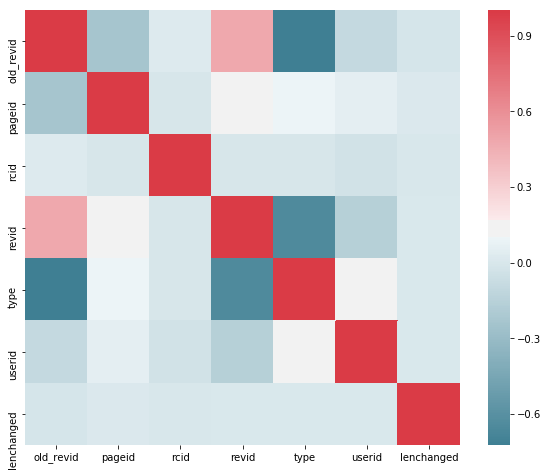

In [30]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
_ = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The matrix shows us a correlation between old and new revision ids, explained by the fact the two numbers are always of the same order of magnitude.

Now, let's take a look at how the types of changes are distributed before and after the hour change.

,type,count
0,edit,100830
1,categorize,50495
2,log,7006
3,new,6069


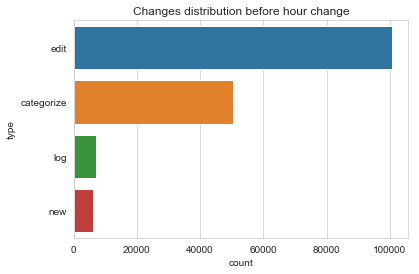

In [31]:
# Distribution of the change type before the hour change
id_to_type = {0: 'edit', 1: 'categorize', 2: 'new', 3: 'log'}
before_categories_df = before_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
before_categories_df.reset_index(level=0, inplace=True)
before_categories_df.type = before_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=before_categories_df).set_title('Changes distribution before hour change')
display(before_categories_df)

,type,count
0,edit,76935
1,categorize,37701
2,log,5805
3,new,4057


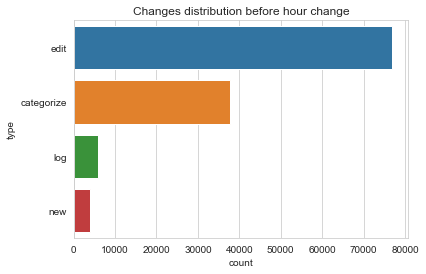

In [32]:
# Distribution of the change type after the hour change
after_categories_df = after_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
after_categories_df.reset_index(level=0, inplace=True)
after_categories_df.type = after_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=after_categories_df).set_title('Changes distribution before hour change')
display(after_categories_df)

In [33]:
# Check the proportions between the counts before and after the hour change for each category
proportions = after_categories_df['count'] / before_categories_df['count']
prop_df = pd.DataFrame({'type': ['edit', 'categorize', 'log', 'new'], 'proportion': proportions})
display(prop_df)

,type,proportion
0,edit,0.763017
1,categorize,0.746628
2,log,0.828576
3,new,0.668479


The distribution of each category seem similar, the difference in numbers being due to the fact that there are more days before than after DST. We could just note that there seems to be a slightly bigger proportion of logs and a smaller proportion of new articles, but the differences are not numerically considerable.

#### Number of Lines

Let's see if there's some modification into the number of lines changed.

In [34]:
# Consider the absolute value in the number of lines changed
edit_before = before_df.loc[before_df['type'] == 0].copy()
edit_before.loc[:, 'lenchanged'] = edit_before.lenchanged.abs()

print('Line change statistics before hour change')
edit_before.lenchanged.describe()

Line change statistics before hour change


count    1.008300e+05
mean     4.196499e+02
std      6.661732e+03
min      0.000000e+00
25%      7.000000e+00
50%      3.700000e+01
75%      1.600000e+02
max      1.115864e+06
Name: lenchanged, dtype: float64

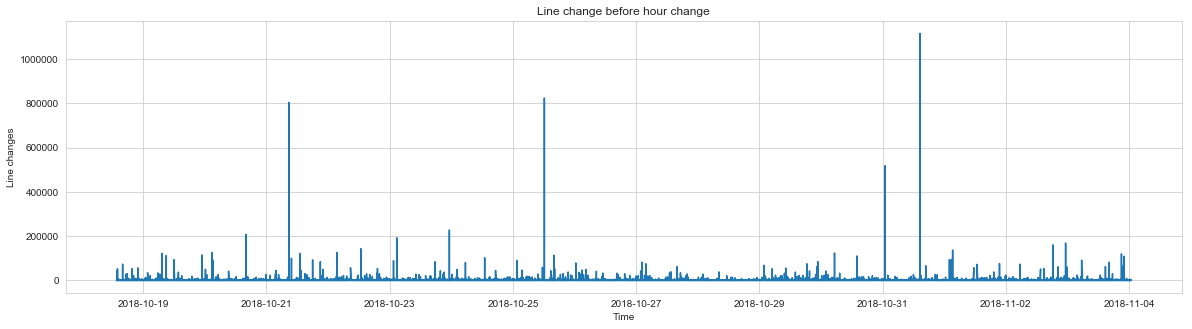

In [35]:
xb = edit_before['timestamp']
yb = edit_before['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xb, yb)
plt.title('Line change before hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

In [36]:
# Consider the absolute value in the number of lines changed
edit_after = after_df.loc[after_df['type'] == 0].copy()
edit_after.lenchanged = edit_after.lenchanged.abs()

print('Line change statistics after hour change')
edit_after.lenchanged.describe()

Line change statistics after hour change


count     76935.000000
mean        509.104400
std        9129.504627
min           0.000000
25%           7.000000
50%          37.000000
75%         173.000000
max      962125.000000
Name: lenchanged, dtype: float64

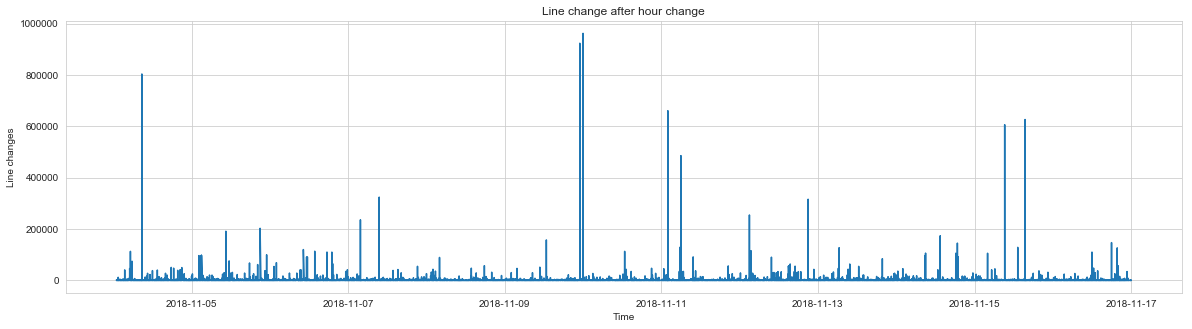

In [37]:
xa = edit_after['timestamp']
ya = edit_after['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xa, ya)
plt.title('Line change after hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

Analysing visually, we can see that number of peaks in the edits done after the hour change is higher than for the period before the hour change.

### Summary

#### Data Handle
The dataset that we collected is quite small (53MB), therefore we don't need to make use of Spark in order to handle it.

In what comes next, we plan to collect more data, so that we can better understand the behaviour evolution before and after the hour change.

#### Understanding the Data
After cleaning and formatting our data to achieve the best possible interpretation, we began to analyze it.
Despite some correlation with no real causality, we have been able to better understand which analysis we should focus on: the dataset is relatively small and the features obtained do not carry a lot of information, we will focus on the activity of people through the amount of data modified before and after the time change.

#### Transform the Data
To improve the accuracy of our work, users' data can be cross-referenced to get their geographic coordinates and get a more accurate idea of the effects of time changes on specific geographic areas.

#### Methodology
Getting a complete analysis with only this dataset is impossible considering its size. This is why it will serve as a validation set for the analysis that we will perform in the data that we are going to collect.
We will therefore split this dataset in a short time interval in order to perform an analysis of the activity on the type of changes of the articles and on the amount of information modified, around the date of the hour change.

### Larger dataset follow-up

In what comes next, we decided to collect a larger dataset comprising all the changes done in the week before and the week after the winter hour change for this year. For this, we once again used the Wikipedia API described above to collect a total of 595 MB of data. Due to the size of the new dataset, we will make use of Spark this time.

In [39]:
# Load the data
EXTENDED_DATA = "./data/wikiExtendedData.json"
wiki_df = spark.read.json(EXTENDED_DATA)

In [40]:
# Inspect the data format
wiki_df.printSchema()
wiki_df.show(10)

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)

+------------+----+------+---------+------+-------+----------+---------+----------+--------------------+----------+----------+--------+
|actionhidden|anon|newlen|old_revid|oldlen| pageid|      rcid|    revid|suppressed|           timestamp|      type|userhidden|  userid|
+------------+----+------+---------+------+-------+----------+---------+----------+--------------------+----------+----------+--------+
|        null|null|  1231|752810129|  1163|8995512|1100026980|866209155|      null|2018-10-29

In [41]:
# Register view to do SQL queries
wiki_df.createOrReplaceTempView("Wiki")

In [42]:
posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
            DATE_FORMAT(timestamp, "yyyy-MM-dd'T'HH") as Date
            FROM Wiki
            GROUP BY Date
            ORDER BY Date ASC""")

posts_date.show(10)

+----------+-------------+
|PostsCount|         Date|
+----------+-------------+
|     10145|2018-10-29T01|
|     10620|2018-10-29T02|
|      9539|2018-10-29T03|
|     10640|2018-10-29T04|
|      7778|2018-10-29T05|
|      6851|2018-10-29T06|
|      6183|2018-10-29T07|
|      6057|2018-10-29T08|
|      7795|2018-10-29T09|
|      6912|2018-10-29T10|
+----------+-------------+
only showing top 10 rows



In [43]:
posts_date_df = posts_date.toPandas()
posts_date_df['Hour'] = posts_date_df['Date'].apply(lambda x: x.split('T')[1])

In [44]:
# Split data in before and after the hour change
before_df = posts_date_df[:167]
after_df = posts_date_df[167:]


before_df = before_df.groupby('Hour').mean()
after_df = after_df.groupby('Hour').mean()

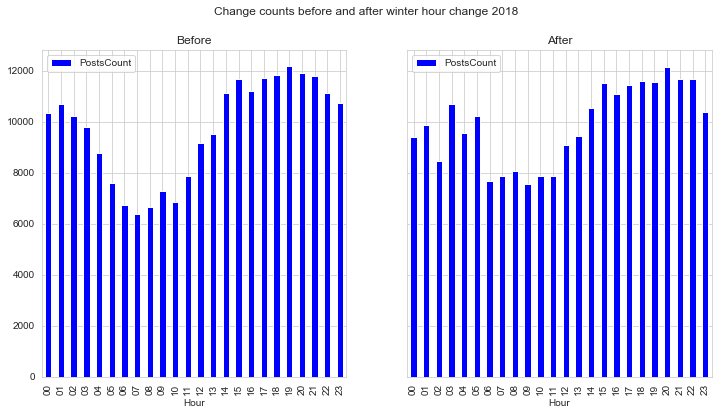

In [45]:
# Plot the count distributions
f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(6)
before_df.groupby('Hour').mean().reset_index().plot.bar(ax=arr[0], x='Hour', y='PostsCount',
                                                        title='Before', color='blue')
_ = after_df.groupby('Hour').mean().reset_index().plot.bar(ax=arr[1], x='Hour', y='PostsCount',
                                                           title='After', color='blue')

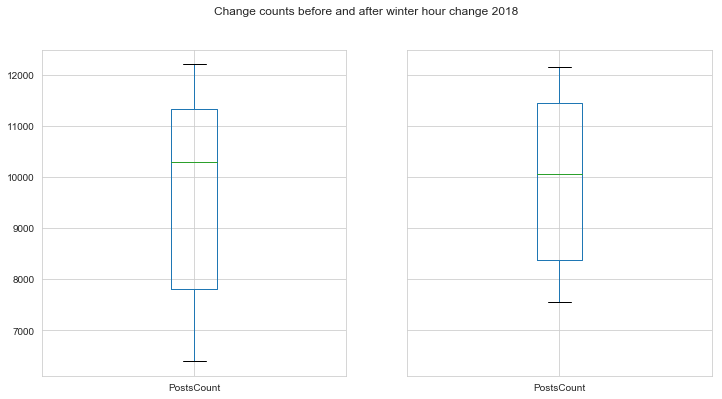

In [46]:
f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(6)

before_df.boxplot(ax=arr[0],column=['PostsCount'])
boxplot2 = after_df.boxplot(ax=arr[1],column=['PostsCount'])

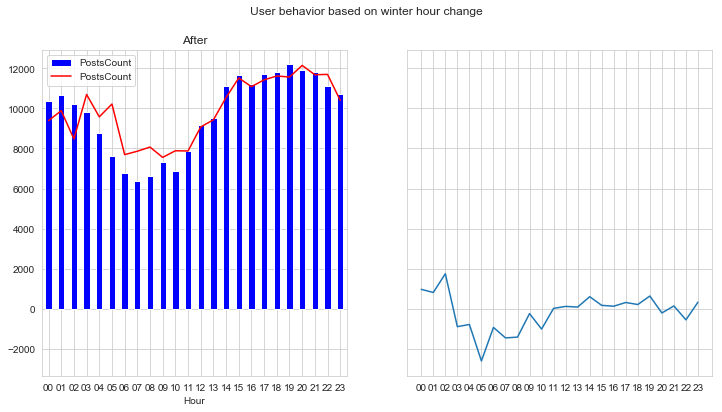

In [47]:
# Plot the count distributions
before = before_df.groupby('Hour').mean().reset_index()
after=after_df.groupby('Hour').mean().reset_index()
f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'User behavior based on winter hour change')
f.set_figwidth(12)
f.set_figheight(6)
before.plot.bar(ax=arr[0], x='Hour', y='PostsCount',title='Before', color='blue')
after.plot(ax=arr[0], x='Hour', y='PostsCount',title='After', color='red')
arr[1].plot(before.Hour,before.PostsCount-after.PostsCount)

As expected, we again see a shift of the peak of the distribution towards the right, from 7 pm to 8 pm.

Estimation of Person correlation (based on data before and after an event analysis)

In [48]:
before_series = before_df.PostsCount.values
after_series = after_df.PostsCount.values

before_mean = before_df.PostsCount.mean()
after_mean = after_df.PostsCount.mean()

print(repr(sp.stats.pearsonr(before_series,after_series)))
print(repr(sp.stats.spearmanr(before_series,after_series)))
print("Quantity of changement: " + repr(before_mean/after_mean))

(0.8880198355211755, 7.067452379705058e-09)
SpearmanrResult(correlation=0.8895652173913042, pvalue=6.110896315326465e-09)
Quantity of changement: 0.9830048514057238


In [49]:
shifted_after = after_series[1:]
compared_before = before_series[:-1]
before_mean = compared_before.mean()
after_mean = shifted_after.mean()

print(repr(sp.stats.pearsonr(compared_before,shifted_after)))
print(repr(sp.stats.spearmanr(compared_before,shifted_after)))
print("Quantity of changement: " + repr(before_mean/after_mean))

(0.9117553237192288, 1.434809755679943e-09)
SpearmanrResult(correlation=0.9209486166007905, pvalue=4.710516603350585e-10)
Quantity of changement: 0.9764552884283738


Correlation increase when data shift is reduced & quantity of changement decreased. Two things can be confirmed: the users have "working habits" with more active time slots than others and that the change of time causes a shift of these habits of plus or minus an hour during the week following the time changement. Indeed, after having visually observed that the distributions before and after the time change are similar to an hour, we checked this with mathematics by comparing the correlations and quantities of change before and after the elimination of the hour shift. 

Graphically, we can say "The afternoon activity is less afect by the hour changement than the morning". we'll try to do a similar analysis to prove it.

In [50]:
#after_df.drop(after_df.tail(3).index,inplace=True)
after_df = after_df.reset_index()
before_df = before_df.reset_index()

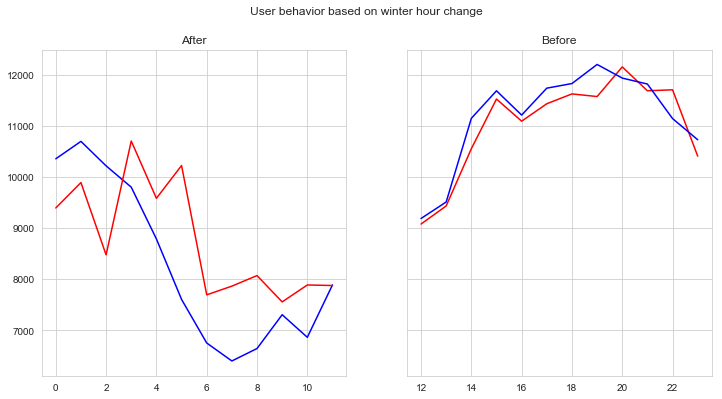

In [51]:
#Morning/afternoon
morning_before= before_df[before_df.Hour < str(12)].PostsCount
morning_after = after_df[after_df.Hour < str(12)].PostsCount
afternoon_before= before_df[before_df.Hour >= str(12)].PostsCount
afternoon_after = after_df[after_df.Hour >= str(12)].PostsCount
#morning_before=pd.concat([pd.Series([np.nan]), morning_before])
#d = {'MorningBefore': morning_before.values, 'AfternoonBefore': afternoon_before.values,'MorningAfter':morning_after.values,'AfternoonAfter':afternoon_after.values}
#time_df = pd.DataFrame(data=d)
#time_df.head()

f, arr = plt.subplots(1, 2, sharey=True)
f.suptitle(f'User behavior based on winter hour change')
f.set_figwidth(12)
f.set_figheight(6)
morning_before.plot(ax=arr[0], x='Hour', y='PostsCount',title='Before', color='blue')
morning_after.plot(ax=arr[0], x='Hour', y='PostsCount',title='After', color='red')
afternoon_after.plot(ax=arr[1], x='Hour', y='PostsCount',title='After', color='red')
afternoon_before.plot(ax=arr[1], x='Hour', y='PostsCount',title='Before', color='blue')

In [52]:
morning_before_mean = morning_before.values.mean()
morning_after_mean = morning_after.values.mean()

print(repr(sp.stats.pearsonr(morning_before.values,morning_after.values)))
print(repr(sp.stats.spearmanr(morning_before.values,morning_after.values)))
print("Quantity of changement: " + repr(morning_before_mean/morning_after_mean))

(0.6594327219072328, 0.019655661115709638)
SpearmanrResult(correlation=0.6363636363636365, pvalue=0.026096891052703127)
Quantity of changement: 0.9439072722350512


In [53]:
afternoon_before_mean = afternoon_before.values.mean()
afternoon_after_mean = afternoon_after.values.mean()

print(repr(sp.stats.pearsonr(afternoon_before.values,afternoon_after.values)))
print(repr(sp.stats.spearmanr(afternoon_before.values,afternoon_after.values)))
print("Quantity of changement: " + repr(afternoon_before_mean/afternoon_after_mean))

(0.9438058787014338, 4.014112194619272e-06)
SpearmanrResult(correlation=0.7412587412587414, pvalue=0.005801150474478243)
Quantity of changement: 1.014109078810348


As we can see with our indicators, the correlation between afternoon before and after hour changement is high and the quantity of changement is close to 1, so there's no changement. For the morning, there's more divergence as we expected.
Now, we'll try to determinated how many days need people to absorb this shift. We'll analyse days after the hour changement

In [54]:
#before_df = posts_date_df[:167]
before = before_df.groupby('Hour').mean().reset_index()
after_df = posts_date_df[167:]

Monday: Before mean: 9725.738095238094 After mean: 10438.666666666666
Tuesday: Before mean: 9725.738095238094 After mean: 9988.958333333334
Wednesday: Before mean: 9725.738095238094 After mean: 9433.291666666666
Thursday: Before mean: 9725.738095238094 After mean: 10592.333333333334
Friday: Before mean: 9725.738095238094 After mean: 9849.0
Saturday: Before mean: 9725.738095238094 After mean: 9515.416666666666
Sunday: Before mean: 9725.738095238094 After mean: 9652.666666666666


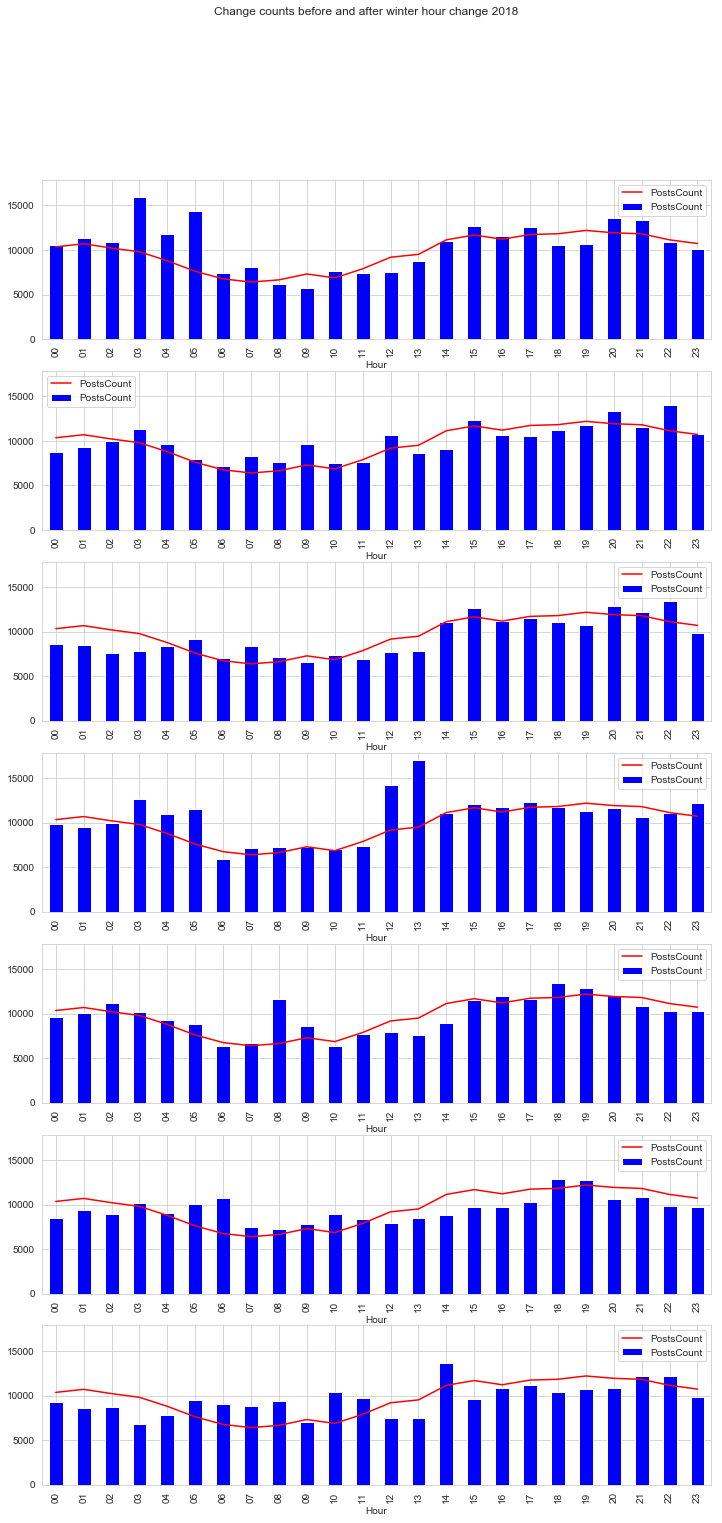

In [55]:
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
f, arr = plt.subplots(7, 1, sharey=True)
f.suptitle(f'Change counts before and after winter hour change 2018')
f.set_figwidth(12)
f.set_figheight(24)
for i in range(7):
    #before = before_df.iloc[i*24:i*24+24]
    after = after_df.iloc[i*24:i*24+24]
    before.plot(ax=arr[i], x='Hour', y='PostsCount', color='red')
    after.reset_index().plot.bar(ax=arr[i], x='Hour', y='PostsCount', color='blue')
    print(days[i]+": Before mean: "+repr(before.PostsCount.mean())+" After mean: "+repr(after.PostsCount.mean()))

TODO : Evolution over a week + time before returning to normal

# DST Impact on the way people go to gym

## Description
The dataset consists of 26,000 people counts (about every 10 minutes) over the last year. In addition, I gathered extra info including weather and semester-specific information that might affect how crowded it is. The label is the number of people, which I'd like to predict given some subset of the features.

Features:
* __date__ (string; datetime of data)
* __timestamp__ (int; number of seconds since beginning of day)
* __day_of_week__ (int; 0 [monday] - 6 [sunday])
* __is_weekend__ (int; 0 or 1) [boolean, if 1, it's either saturday or sunday, otherwise 0]
* __is_holiday__ (int; 0 or 1) [boolean, if 1 it's a federal holiday, 0 otherwise]
* __temperature__ (float; degrees fahrenheit)
* __is_start_of_semester__ (int; 0 or 1) [boolean, if 1 it's the beginning of a school semester, 0 otherwise]
* __month__ (int; 1 [jan] - 12 [dec])
* __hour__ (int; 0 - 23)

In [5]:
DATA_DIR = 'data'
traffic_data = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [6]:
display(traffic_data['date'].describe())
display(traffic_data['date'].min())
display(traffic_data['date'].max())

count                         62184
unique                        62184
top       2015-08-15 06:50:20-07:00
freq                              1
Name: date, dtype: object

'2015-08-14 17:00:11-07:00'

'2017-03-18 19:22:51-07:00'

### Time Changes in Los Angeles Over the Years
#### Daylight Saving Time (DST) changes do not necessarily occur on the same date every year.

| Year | Date & Time | Abbreviation | Time Change | Offset After |
|------|-------------|--------------|-------------|--------------|
| 2015 | Sun, 8 Mar, 02:00  | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2015 | Sun, 1 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2016 | Sun, 13 Mar, 02:00 | PST → PDT	| +1 hour (DST start) | UTC-7h |
| 2016 | Sun, 6 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |
| 2017 | Sun, 12 Mar, 02:00 | PST → PDT | +1 hour (DST start) | UTC-7h |
| 2017 | Sun, 5 Nov, 02:00  | PDT → PST | -1 hour (DST end)   | UTC-8h |

Seems like we have the all of the DST changes except the first and the last one. Let's split our data set to reflect these disjoint periods.

First, we will convert the date to UTC (for convenience, later)

In [7]:
traffic_data['date_utc'] = pd.to_datetime(traffic_data['date'], infer_datetime_format=True)
traffic_data.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour,date_utc
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17,2015-08-15 00:00:11
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17,2015-08-15 00:20:14
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17,2015-08-15 00:30:15
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17,2015-08-15 00:40:16
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17,2015-08-15 00:50:17


Second, since we see that the data contains information about the timezone, and the timezone changes as part of the DST change, we can take advantage of this. Basically we split our data set based on continous sequences that have the same timezone offset.

In [8]:
diff = np.diff(traffic_data['date'].str.contains("-07:00"))
ind_split = np.where(diff == True)[0]
traffic_periods = [
    traffic_data.iloc[:ind_split[0]],
    traffic_data.iloc[ind_split[0]:ind_split[1]],
    traffic_data.iloc[ind_split[1]:ind_split[2]],
    traffic_data.iloc[ind_split[2]:ind_split[3]],
    traffic_data.iloc[ind_split[3]:],
]
# Check if they have the same size
assert(len(traffic_periods[0]) + len(traffic_periods[1]) + len(traffic_periods[2]) + len(traffic_periods[3]) + len(traffic_periods[4]) == len(traffic_data))

Now, let's try to see if we find something interesting in the data on each period. We will start by checking basic statictics about the number of people in each traffic period.

In [9]:
for index, traffic_period in enumerate(traffic_periods):
    print(f"Period {index}: {traffic_period['number_people'].describe()}")
    print(f"Total count: \t{traffic_period['number_people'].sum()}")

Period 0: count    7637.000000
mean       49.393741
std        26.060209
min         0.000000
25%        33.000000
50%        52.000000
75%        68.000000
max       145.000000
Name: number_people, dtype: float64
Total count: 	377220
Period 1: count    12963.000000
mean        39.196174
std         25.227458
min          0.000000
25%         20.000000
50%         42.000000
75%         57.000000
max        138.000000
Name: number_people, dtype: float64
Total count: 	508100
Period 2: count    30571.000000
mean        24.050505
std         17.501287
min          0.000000
25%          8.000000
50%         25.000000
75%         36.000000
max        108.000000
Name: number_people, dtype: float64
Total count: 	735248
Period 3: count    10347.000000
mean        16.705132
std         14.661597
min          0.000000
25%          1.000000
50%         17.000000
75%         29.000000
max         88.000000
Name: number_people, dtype: float64
Total count: 	172848
Period 4: count    666.000000
mean  

Also let's note the periods we have so far, and their corresponding months

|Period #| Month spans | Data Points |
|--------|-------------|-------------|
|0       |Aug'15-Nov'15|7637         |
|1       |Nov'15-Mar'16|12963        |
|2       |Mar'16-Nov'16|30571        |
|3       |Nov'16-Mar'17|10347        |
|4       |Mar'17-Mar'17|666          |
|_       |Total        |62184        |

From this table, we can see that the last period contains a very small amount of collected data. Indeed, we have data collected only one week after the DST change.

Another note that we have to make is that for the first period we have only 4 months of data from the whole 9 months of the 2014-2015 DST period.

Let's plot the total number of gym 'visits' (**workouts**) in those periods.

[377220, 508100, 735248, 172848, 14431]


<BarContainer object of 5 artists>

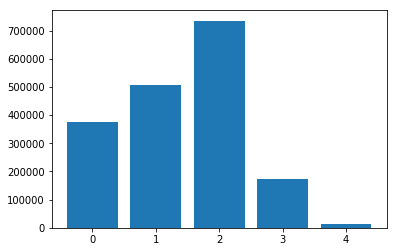

In [10]:
total_count = []

for index, traffic_period in enumerate(traffic_periods):
    total_count.append(traffic_period['number_people'].sum())
print(total_count)
plt.bar(x = range(len(total_count)), height = total_count)

Ignoring the first and the last period, based on the above notes, an interesting observation we can make from this plot is that in the Nov'15-Mar'16 period, the total number of workout sessions was more than twice that number in the same period of the next year (Nov'16-Mar'17). Said differently, the number of session workouts dropped by more than half one year after.

### Monthly statistics
We will increase the granularity of our analysis on a monthly basis.

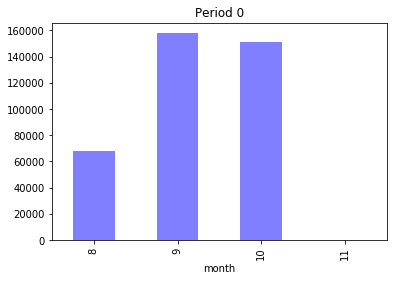

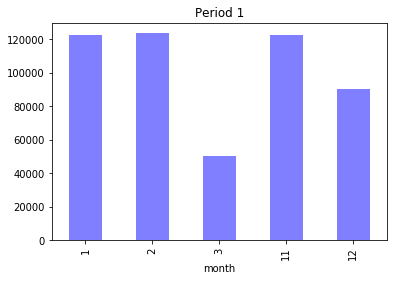

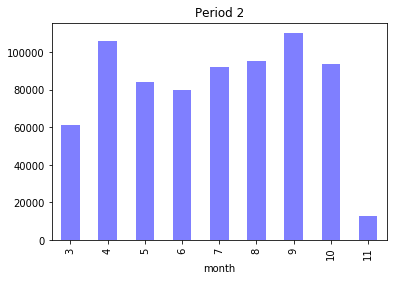

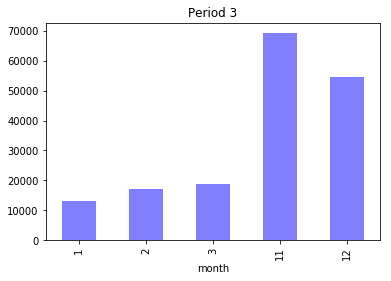

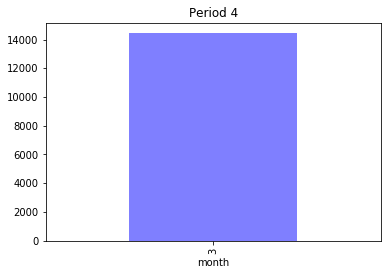

In [11]:
def plot_monthly_stats(traffic_period, index):
    #display(traffic_period.groupby('month')['number_people'].agg('sum'))
    traffic_period.groupby('month')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5)
    plt.title(f"Period {index}")
    plt.show()
    #traffic_period.hist(column = 'number_people', by='month')
for index, traffic_period in enumerate(traffic_periods):
    plot_monthly_stats(traffic_period, index)

# One month before and after DST
Let's now focus our analysis only on the month before and after the hour change, in order to look for more interesting pattern changes. 

In [14]:
for index in range(len(traffic_periods) - 1):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    print(f"Time change #{index}")
    print(f"Data points one month before: {len(one_month_before_dst)}")
    print(f"Data points one month after: {len(one_month_after_dst)}")

Time change #0
Data points one month before: 2934
Data points one month after: 2905
Time change #1
Data points one month before: 2905
Data points one month after: 2948
Time change #2
Data points one month before: 4124
Data points one month after: 4212
Time change #3
Data points one month before: 1384
Data points one month after: 666


We will ignore the last change, becaue we only have 8 days available on the period after the March 2017 time change, and not enough data points.
In order to visualise this data, we could plot the distrubtion of the number of people on every day of the week. That makes sense from the perspective of our data domain (since most of the workouts programs are tailored on a week by week basis - ie Monday - Leg day, Friday - Arms day 💪)

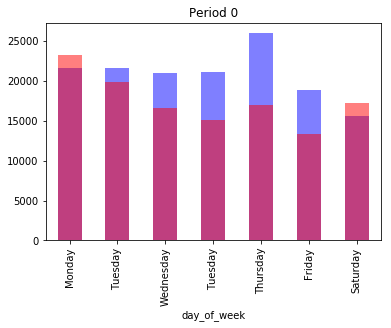

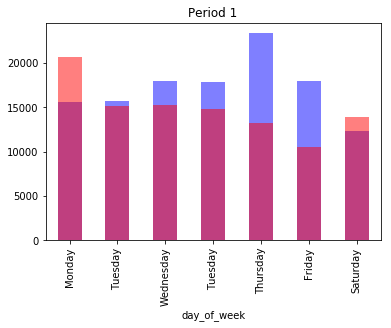

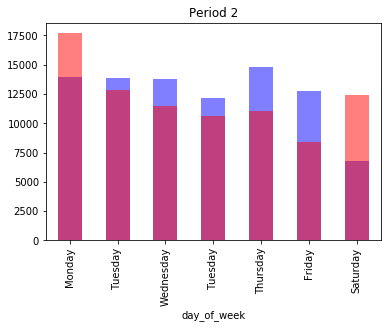

In [15]:
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    ax = one_month_before_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='blue', alpha=0.5)
    one_month_after_dst.groupby('day_of_week')['number_people'].agg('sum').plot.bar(color='red', alpha=0.5, ax = ax)
    plt.title(f"Period {index}")
    ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.show()

We can see the results are pretty consistent. The distributions skews to the left, perhaps because people are thinking about going to the gym as early as possible. We can think of this as the "New Year's Resolution" effect when people are very motivated to start going to the gym an eating healthy right after the New Year's Eve, but they loose momentun in the following months.

## Heatmaps

Let's not try to plot a color matrix for each day of the week and for each hour.

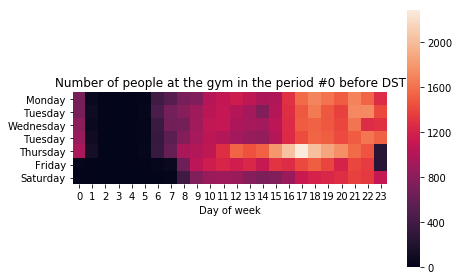

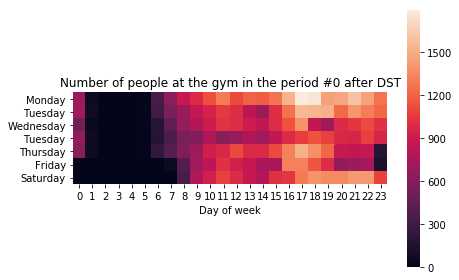

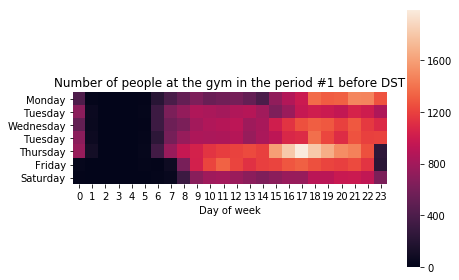

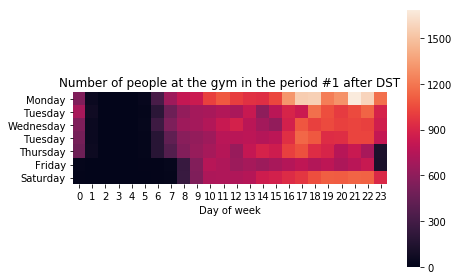

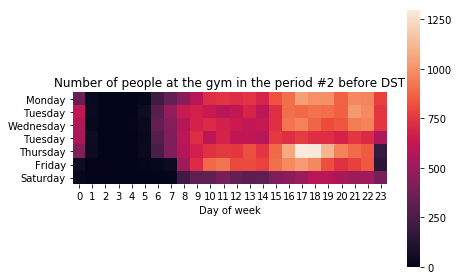

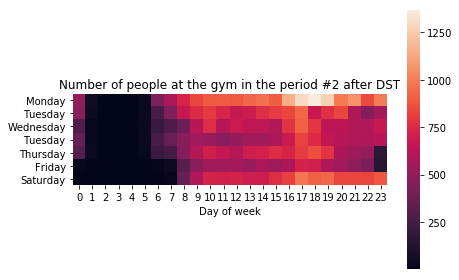

In [16]:
def plot_heatmap(df, index, after = False):
    myMap = np.zeros(shape = [7, 24])
    for row in df.iterrows():
        myMap[row[1]['day_of_week'], row[1]['hour']] += row[1]['number_people']
    ax = sns.heatmap(myMap, square=True)
    plt.tight_layout()
    if after:
        plt.title(f"Number of people at the gym in the period #{index} after DST")
    else:
        plt.title(f"Number of people at the gym in the period #{index} before DST")
    plt.xlabel("Day of week")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.set_yticklabels(["Monday", "Tuesday", "Wednesday", "Tuesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    plot_heatmap(one_month_before_dst, index)
    plot_heatmap(one_month_after_dst, index, after = True)

It can be seen from this heatmaps that the number of coming early in the morning (6am) increases after the DST - which makes sense, and we were expecting that.

__A very interesting pattern that we notice is that on every change, the highest traffic at the gym before the change was always on Thursdays (white squares) afternoon, between 14-20, and the cluster after was always on Mondays on pretty much the same period.__

Let's now aggregate the days based on the hours.

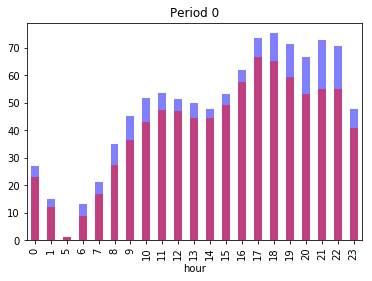

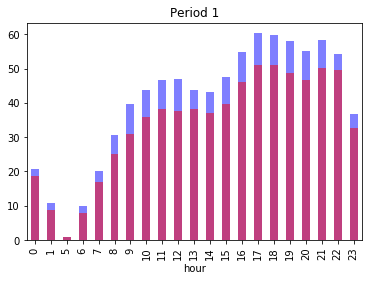

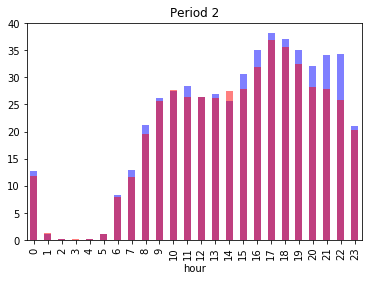

In [17]:
for index in range(len(traffic_periods) - 2):
    period_before = traffic_periods[index]
    period_after = traffic_periods[index + 1]
    one_month_before_dst = period_before[period_before['date_utc'] >= (period_before['date_utc'].max() - timedelta(30))]
    one_month_after_dst = period_after[period_after['date_utc'] <= (period_after['date_utc'].min() + timedelta(30))]
    ax = one_month_before_dst.groupby('hour')['number_people'].mean().plot.bar(color='blue', alpha=0.5)
    one_month_after_dst.groupby('hour')['number_people'].mean().plot.bar(color='red', alpha=0.5, ax = ax)
    plt.title(f"Period {index}")
    plt.show()

We can see that the distribution of the mean number of people on each our is decreasing with some very very rare cases. So, nothing very conclusive here.
